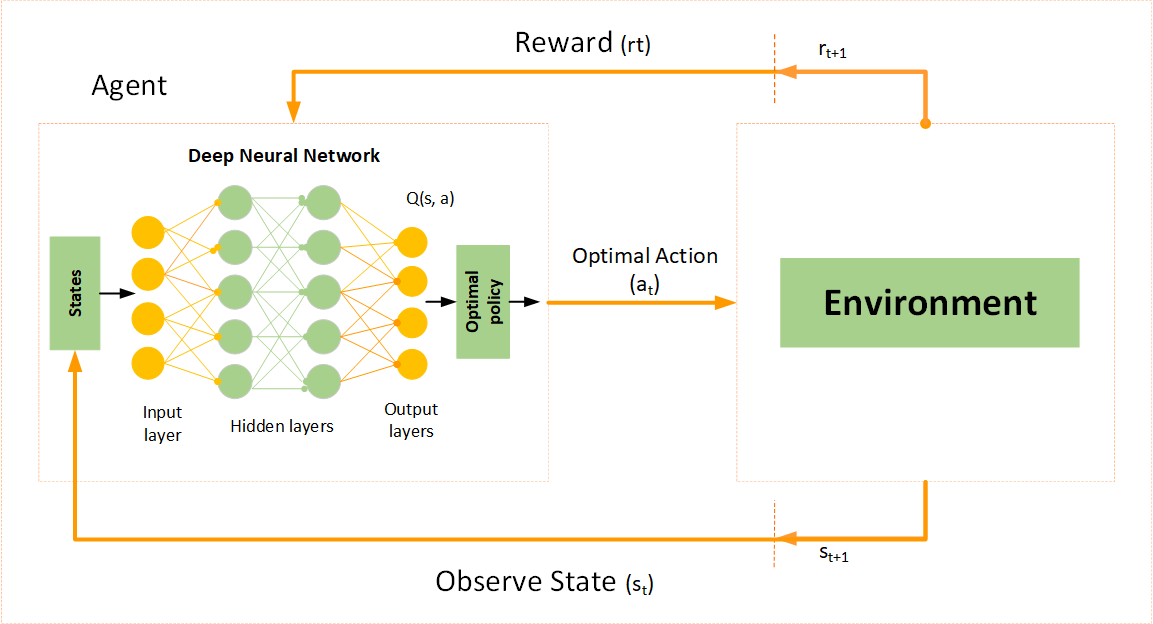

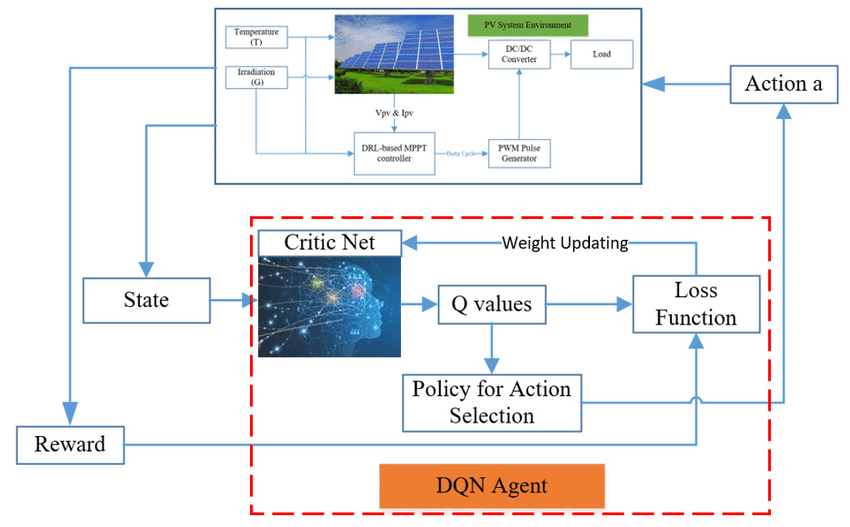

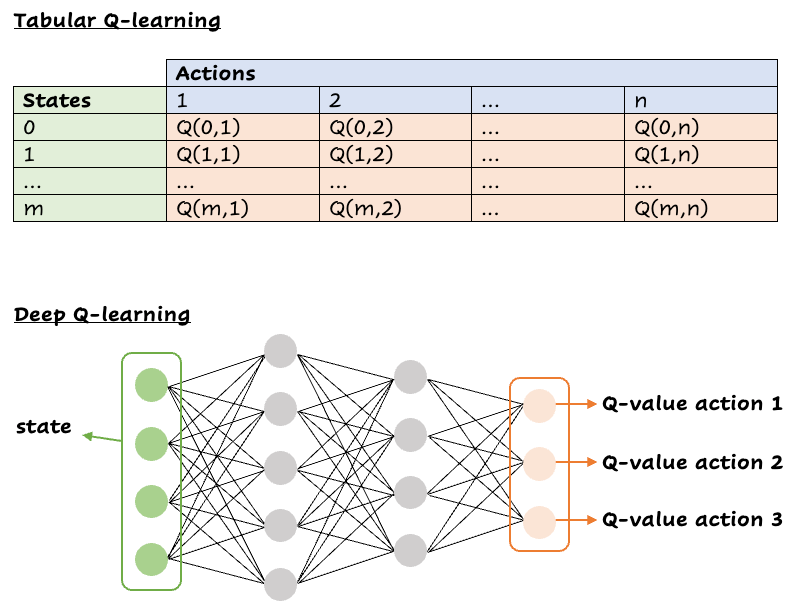

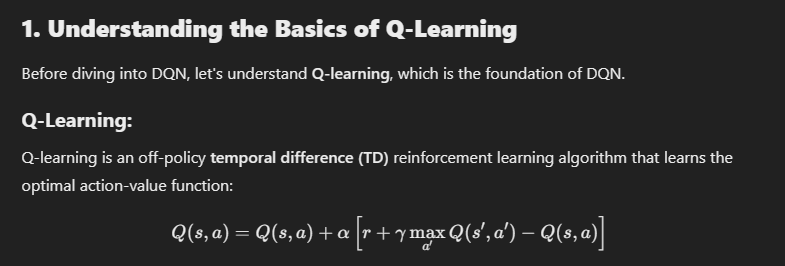

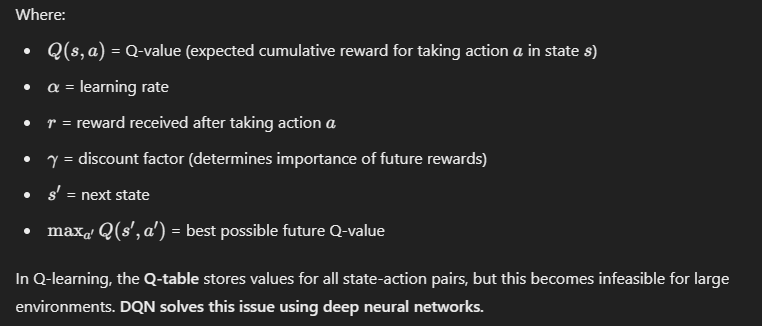

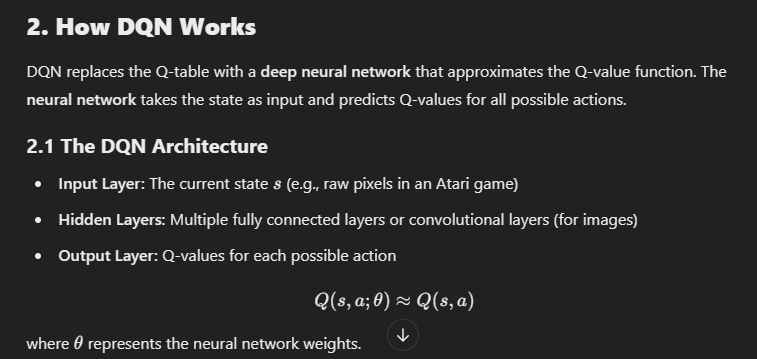

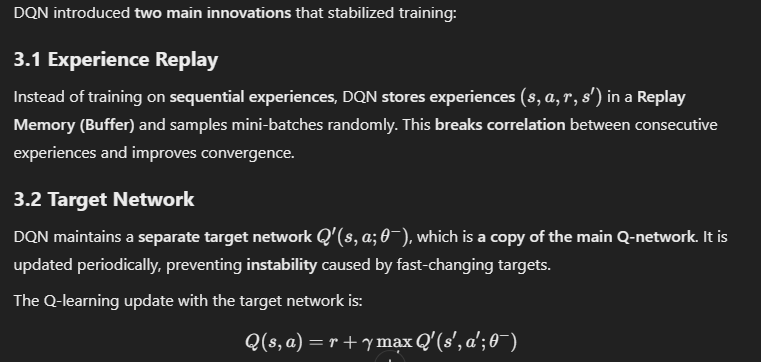

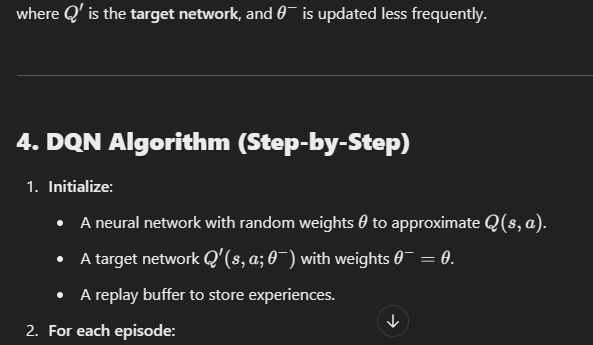

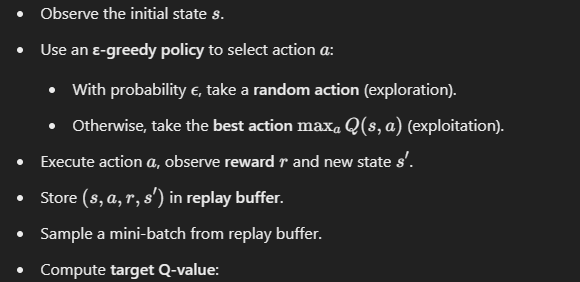

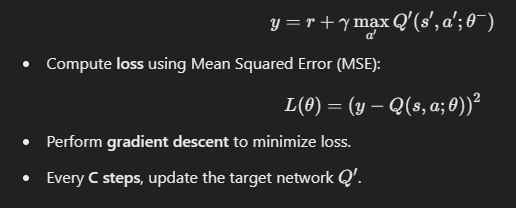

In [1]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque

# Define DQN Model
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Hyperparameters
GAMMA = 0.99
LR = 1e-3
BATCH_SIZE = 32
MEMORY_SIZE = 10000
EPSILON = 1.0
EPSILON_DECAY = 0.995
MIN_EPSILON = 0.01

# Experience Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

# Training Function
def train(env, model, target_model, optimizer, buffer, episodes=500):
    global EPSILON
    for episode in range(episodes):
        state = env.reset()[0]  # Reset environment and get initial state
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)

        total_reward = 0
        done = False
        while not done:
            # Select action using ε-greedy policy
            if random.random() < EPSILON:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    action = torch.argmax(model(state)).item()

            # Take action in the environment
            next_state, reward, done, _, _ = env.step(action)
            next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)
            buffer.add((state, action, reward, next_state, done))

            state = next_state
            total_reward += reward

            # Training step
            if len(buffer.buffer) >= BATCH_SIZE:
                batch = buffer.sample(BATCH_SIZE)
                states, actions, rewards, next_states, dones = zip(*batch)

                states = torch.cat(states)
                actions = torch.tensor(actions).unsqueeze(1)
                rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1)
                next_states = torch.cat(next_states)
                dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1)

                # Compute target Q-values
                with torch.no_grad():
                    target_Q = rewards + GAMMA * torch.max(target_model(next_states), dim=1, keepdim=True)[0] * (1 - dones)

                # Compute predicted Q-values
                predicted_Q = model(states).gather(1, actions)

                # Compute loss and update model
                loss = nn.MSELoss()(predicted_Q, target_Q)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Update target network every 10 episodes
        if episode % 10 == 0:
            target_model.load_state_dict(model.state_dict())

        # Decay epsilon
        EPSILON = max(MIN_EPSILON, EPSILON * EPSILON_DECAY)
        print(f"Episode {episode}, Reward: {total_reward}")

# Run training
env = gym.make("CartPole-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

model = DQN(state_dim, action_dim)
target_model = DQN(state_dim, action_dim)
target_model.load_state_dict(model.state_dict())

optimizer = optim.Adam(model.parameters(), lr=LR)
buffer = ReplayBuffer(MEMORY_SIZE)

train(env, model, target_model, optimizer, buffer)


AttributeError: module 'numpy' has no attribute 'bool8'

Adding Chain of Thought (CoT) reasoning to DQN enhances its decision-making process by enabling intermediate reasoning steps. Instead of directly mapping states to actions, the agent generates a structured thought process before making a decision. This helps in complex environments where multi-step reasoning is crucial.

In [ ]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque

# Define DQN with Chain of Thought (CoT)
class DQN_CoT(nn.Module):
    def __init__(self, state_dim, action_dim, cot_steps=3):
        super(DQN_CoT, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.cot_steps = cot_steps
        
        # Chain of Thought reasoning layers
        self.cot_layers = nn.ModuleList([nn.Linear(128, 128) for _ in range(cot_steps)])
        
        # Output Q-values
        self.q_out = nn.Linear(128, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))

        cot_outputs = []
        for layer in self.cot_layers:
            x = torch.relu(layer(x))
            cot_outputs.append(x)  # Store CoT intermediate steps
        
        q_values = self.q_out(x)  # Final Q-values
        return q_values, cot_outputs  # Return both Q-values and reasoning steps

# Hyperparameters
GAMMA = 0.99
LR = 1e-3
BATCH_SIZE = 32
MEMORY_SIZE = 10000
EPSILON = 1.0
EPSILON_DECAY = 0.995
MIN_EPSILON = 0.01

# Experience Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

# Training Function
def train(env, model, target_model, optimizer, buffer, episodes=500):
    global EPSILON
    for episode in range(episodes):
        state = env.reset()[0]  
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)

        total_reward = 0
        done = False
        while not done:
            # Select action using ε-greedy policy
            if random.random() < EPSILON:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    q_values, cot_steps = model(state)  # Get Q-values and CoT reasoning
                    action = torch.argmax(q_values).item()

            # Take action in environment
            next_state, reward, done, _, _ = env.step(action)
            next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)
            buffer.add((state, action, reward, next_state, done))

            state = next_state
            total_reward += reward

            # Training step
            if len(buffer.buffer) >= BATCH_SIZE:
                batch = buffer.sample(BATCH_SIZE)
                states, actions, rewards, next_states, dones = zip(*batch)

                states = torch.cat(states)
                actions = torch.tensor(actions).unsqueeze(1)
                rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1)
                next_states = torch.cat(next_states)
                dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1)

                # Compute target Q-values
                with torch.no_grad():
                    target_Q, _ = target_model(next_states)
                    target_Q = rewards + GAMMA * torch.max(target_Q, dim=1, keepdim=True)[0] * (1 - dones)

                # Compute predicted Q-values
                predicted_Q, cot_steps_pred = model(states)
                predicted_Q = predicted_Q.gather(1, actions)

                # Compute loss: Q-learning loss + CoT loss
                q_loss = nn.MSELoss()(predicted_Q, target_Q)
                cot_loss = sum([torch.mean(step) for step in cot_steps_pred])  # Encourage CoT steps to be meaningful
                total_loss = q_loss + 0.01 * cot_loss  # Small weight for CoT loss

                optimizer.zero_grad()
                total_loss.backward()
                optimizer.step()

        # Update target network every 10 episodes
        if episode % 10 == 0:
            target_model.load_state_dict(model.state_dict())

        # Decay epsilon
        EPSILON = max(MIN_EPSILON, EPSILON * EPSILON_DECAY)
        print(f"Episode {episode}, Reward: {total_reward}")

# Run training
env = gym.make("CartPole-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

model = DQN_CoT(state_dim, action_dim)
target_model = DQN_CoT(state_dim, action_dim)
target_model.load_state_dict(model.state_dict())

optimizer = optim.Adam(model.parameters(), lr=LR)
buffer = ReplayBuffer(MEMORY_SIZE)

train(env, model, target_model, optimizer, buffer)
